In [1]:
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, auc,roc_auc_score
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings("ignore")
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.impute import KNNImputer #importing knn imputer to fill the missing values
import matplotlib.pyplot as plt



In [2]:
#df1=pd.read_csv("/Users/pruthvikbr/Documents/UCI/Machine Learning/Assignment 3/SCT-Data-A-1.csv")
#df2=pd.read_csv("/Users/pruthvikbr/Documents/UCI/Machine Learning/Assignment 3/SCT-Data-B-1.csv")

In [3]:
#data=pd.merge(df1,df2,on='ID')
#data.tail()

In [4]:

#importing the data
df1=pd.read_csv("/Users/pruthvikbr/Documents/UCI/Machine Learning/Assignment 3/SCT-Data-A-1.csv")
df2=pd.read_csv("/Users/pruthvikbr/Documents/UCI/Machine Learning/Assignment 3/SCT-Data-B-1.csv")
df2.drop(columns=['ID'], inplace=True)
data = pd.concat([df1, df2], axis=1)
#because the last line of the data contains unwanted string
#data['ID'][2391] = data['ID'][2391].replace('Data source: Company data adjusted by author using unspecified constants.', '')
data.drop(data.index[-1], inplace=True)
pd.set_option("display.max_columns",None)

#Cleaning the data

#making a list of float type columns because knn imputer only works on numerical values
float_columns = data.select_dtypes(include=['float64']).columns.tolist()
imputer=KNNImputer(n_neighbors=2,weights="uniform") #initialising the imputer method
data[float_columns]=imputer.fit_transform(data[float_columns])



########-----########
#making a list of object type columns because knn imputer only works on numerical values. we'll be using other tokenization methods
object_columns = data.select_dtypes(include=['object']).columns.tolist()

# Initialize a dictionary to store vectorizers for each column
vectorizers = {}

# Get English stop words
stop_words = set(stopwords.words('english'))

# Define a custom tokenizer that removes stop words
def custom_tokenizer(text):
    tokens = word_tokenize(text)
    return [word for word in tokens if word.lower() not in stop_words]

# Iterate over each column for imputation
for column in object_columns:
    if data[column].notnull().sum() > 0:  # Check if there are non-missing values in the column
        # Preprocessing and Feature Extraction
        vectorizers[column] = CountVectorizer(min_df=1, tokenizer=custom_tokenizer)  # Adjust min_df parameter and use custom tokenizer
        X_train = vectorizers[column].fit_transform(data[column].dropna())  # Use non-missing values for training
        y_train = data[column].dropna()

        # Model Training
        clf = RandomForestClassifier()  # You can use any other model here
        clf.fit(X_train, y_train)  # Train the classifier on non-missing values

        # Imputation
        missing_indices = data[column].isnull()
        if missing_indices.sum() > 0:  # Check if there are missing values to impute
            X_missing = vectorizers[column].transform(data.loc[missing_indices, column].fillna(''))
            imputed_values = clf.predict(X_missing)

            # Update DataFrame with imputed values
            data.loc[missing_indices, column] = imputed_values
data['Retained.in.2012.']=data['Retained.in.2012.'].astype(int)

df=data



Confusion Matrix:
 [[ 95 114]
 [ 51 219]]


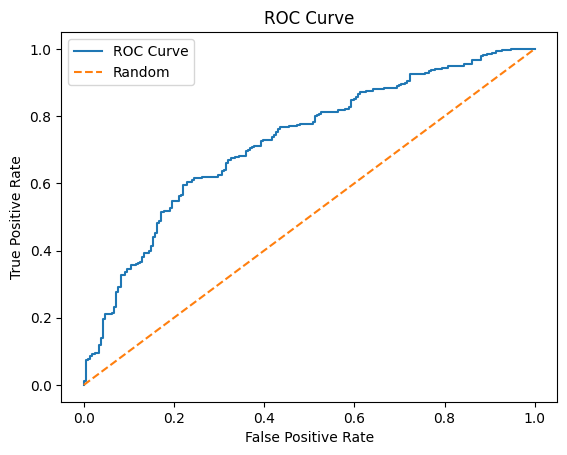

AUC Score: 0.723693071061492
Odds Ratios: [1.05981776 0.87362202 0.92539478 ... 1.00018273 1.00007916 1.00037158]


In [5]:
# Convert categorical variables into dummy/indicator variables (one-hot encoding)
data = pd.get_dummies(data, columns=object_columns, drop_first=True)

# Splitting the data into train and test sets
X = data.drop(columns=['Retained.in.2012.'])
y = data['Retained.in.2012.']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression
logit_model = LogisticRegression()
logit_model.fit(X_train, y_train)

# Predictions
y_pred = logit_model.predict(X_test)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# ROC Curve and AUC
y_probs = logit_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# AUC Score
auc_score = roc_auc_score(y_test, y_probs)
print("AUC Score:", auc_score)

# Odds Ratios
coefficients = logit_model.coef_[0]
odds_ratios = np.exp(coefficients)
print("Odds Ratios:", odds_ratios)


In [6]:
#Decision Tree

Confusion Matrix for CART:
[[143  66]
 [ 55 215]]


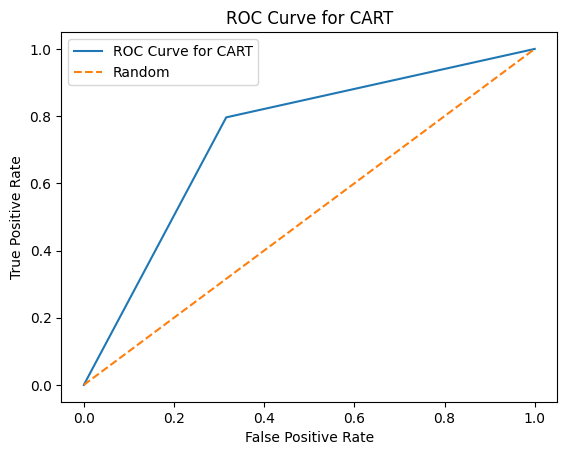

AUC Score for CART: 0.7402534113060429


In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Define CART model
cart_model = DecisionTreeClassifier()

# Train the CART model
cart_model.fit(X_train, y_train)

# Predictions
y_pred_cart = cart_model.predict(X_test)

# Confusion Matrix
conf_matrix_cart = confusion_matrix(y_test, y_pred_cart)
print("Confusion Matrix for CART:")
print(conf_matrix_cart)

# ROC Curve and AUC
y_probs_cart = cart_model.predict_proba(X_test)[:, 1]
fpr_cart, tpr_cart, thresholds_cart = roc_curve(y_test, y_probs_cart)
plt.plot(fpr_cart, tpr_cart, label='ROC Curve for CART')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for CART')
plt.legend()
plt.show()

# AUC Score
auc_score_cart = roc_auc_score(y_test, y_probs_cart)
print("AUC Score for CART:", auc_score_cart)


In [8]:
#Random Forest

Confusion Matrix for Random Forest:
[[126  83]
 [ 36 234]]


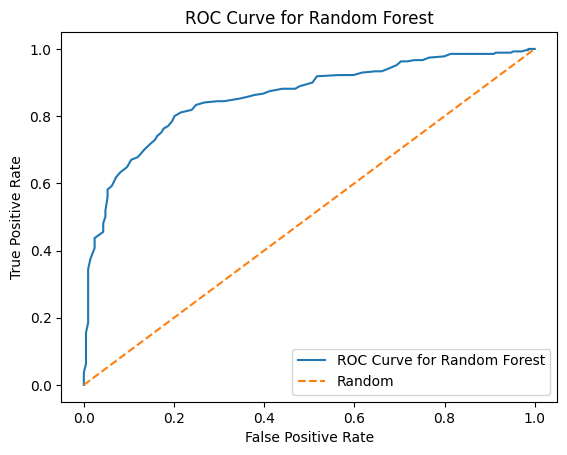

AUC Score for Random Forest: 0.8580985291511607


In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Define Random Forest model
rf_model = RandomForestClassifier()

# Train the Random Forest model
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Confusion Matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix for Random Forest:")
print(conf_matrix_rf)

# ROC Curve and AUC
y_probs_rf = rf_model.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_probs_rf)
plt.plot(fpr_rf, tpr_rf, label='ROC Curve for Random Forest')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest')
plt.legend()
plt.show()

# AUC Score
auc_score_rf = roc_auc_score(y_test, y_probs_rf)
print("AUC Score for Random Forest:", auc_score_rf)


In [10]:
#XGBOOST

Confusion Matrix for XGBoost:
[[140  69]
 [ 46 224]]


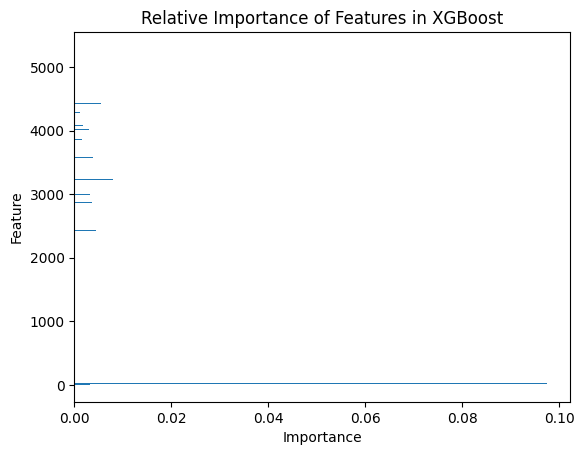

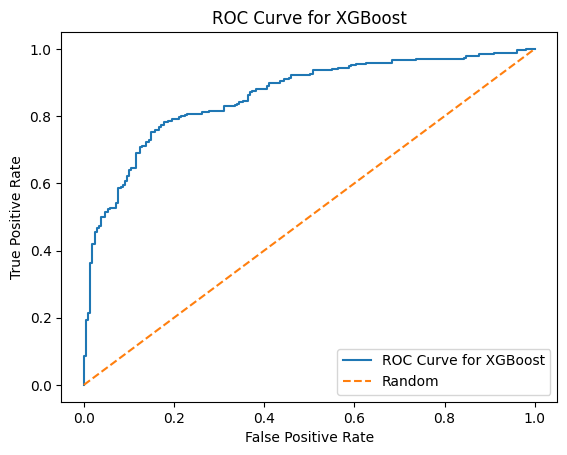

AUC Score for XGBoost: 0.8598794967216021


In [11]:
import xgboost as xgb
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Define XGBoost model
xgb_model = xgb.XGBClassifier()

# Train the XGBoost model
xgb_model.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_model.predict(X_test)

# Confusion Matrix
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
print("Confusion Matrix for XGBoost:")
print(conf_matrix_xgb)

# Relative Importance of the Features
plt.barh(range(len(xgb_model.feature_importances_)), xgb_model.feature_importances_)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Relative Importance of Features in XGBoost')
plt.show()

# ROC Curve and AUC
y_probs_xgb = xgb_model.predict_proba(X_test)[:, 1]
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_probs_xgb)
plt.plot(fpr_xgb, tpr_xgb, label='ROC Curve for XGBoost')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost')
plt.legend()
plt.show()

# AUC Score
auc_score_xgb = roc_auc_score(y_test, y_probs_xgb)
print("AUC Score for XGBoost:", auc_score_xgb)


In [12]:
# STEPWISE LOGISTIC 

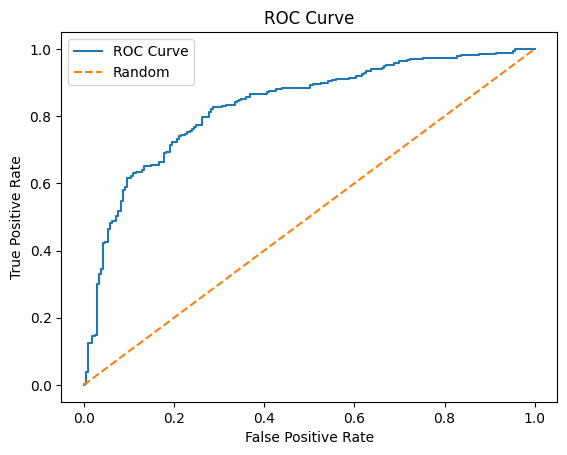

AUC Score: 0.8314548998759526
Odds Ratios: [0.11939154 1.04960822 2.08495905 0.99711362 3.9114282  0.62036742
 0.75974329 1.0992376 ]


In [13]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Splitting the data into train and test sets
X=df[float_columns]
X = X.drop(columns=['Retained.in.2012.'])
y = df['Retained.in.2012.']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define logistic regression model
logit_model = LogisticRegression()

# Perform stepwise selection
sfs = SFS(logit_model, 
          k_features='best', 
          forward=True, 
          floating=False, 
          scoring='accuracy',
          cv=5)

sfs.fit(X_train, y_train)

# Get the selected features
selected_features = list(sfs.k_feature_names_)

# Train the model with selected features
logit_model.fit(X_train[selected_features], y_train)

# Predictions
y_pred = logit_model.predict(X_test[selected_features])

# ROC Curve and AUC
y_probs = logit_model.predict_proba(X_test[selected_features])[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# AUC Score
auc_score = roc_auc_score(y_test, y_probs)
print("AUC Score:", auc_score)

# Odds Ratios
coefficients = logit_model.coef_[0]
odds_ratios = np.exp(coefficients)
print("Odds Ratios:", odds_ratios)
